## 0.0 Imports

In [166]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [167]:
'''
!pip install inflection
'''

'\n!pip install inflection\n'

### 0.1 Helper Functions

### 0.2 Load Data

In [168]:
#low_memory le o arquivo inteiro e não por pedaços
df_sales_raw = pd.read_csv('./data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('./data/store.csv', low_memory=False)

#merge dos dataframes(defino o df de referencia, o que sera acrescentado, o modo de operação e a coluna referencia)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')


In [169]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.0 Descrição dos dados

In [170]:
df1 = df_raw.copy()

### 1.1 Rename Columns

In [171]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [172]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

#utilizo o inflection para aplicar o snake_case nos nomes das colunas
snkcase = lambda x: inflection.underscore( x )
cols_new = list(map(snkcase, cols_old))

# rename columns
df1.columns = cols_new

### 1.2 Data Dimensions

In [173]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


### 1.3 Data Types

In [174]:
#mudo o tipo da coluna date de object para o tipo datetime
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [175]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [176]:
df1['competition_distance'].max()

75860.0

In [177]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
652194,705,7,2013-11-24,0,0,0,0,0,0,a,a,4140.0,9.0,2012.0,1,18.0,2011.0,"Feb,May,Aug,Nov"


In [178]:
# competition_distance
# a ausencia de dados pode significar uma grande distancia entre os concorrentes, logo aplico nesses dados faltantes 
# um numero maior que a distancia maxima encontrada.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
#a ausencia de dados pode significar que o concorrente abriu depois da abertura da loja
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)
# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week
#ausencia de dados pode significar que a loja 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
# promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval
month_map = {1:'Jan',
             2:'Feb',
             3:'Mar',
             4:'Apr',
             5:'May',
             6:'Jun',
             7:'Jul',
             8:'Aug',
             9:'Sep',
             10:'Oct',
             11:'Nov',
             12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [179]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
dtype: int64

In [180]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [181]:
df1.head(5).T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


### 1.6 Change Types

In [182]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [183]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [184]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7 Descriptive Statistical

In [185]:
num_att = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_att = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

In [186]:
num_att.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 14 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   sales                         1017209 non-null  int64  
 3   customers                     1017209 non-null  int64  
 4   open                          1017209 non-null  int64  
 5   promo                         1017209 non-null  int64  
 6   school_holiday                1017209 non-null  int64  
 7   competition_distance          1017209 non-null  float64
 8   competition_open_since_month  1017209 non-null  int32  
 9   competition_open_since_year   1017209 non-null  int32  
 10  promo2                        1017209 non-null  int64  
 11  promo2_since_week             1017209 non-null  int32  
 12  promo2_since_year           

#### 1.7.1 Numerical Attributes

In [187]:
#tendencia central - media e mediana
ct1 = pd.DataFrame(num_att.apply(np.mean)).T
ct2 = pd.DataFrame(num_att.apply(np.median)).T

#dispersao - desvio padrao, minimo, max, range, skew e kurtosis
d1 = pd.DataFrame(num_att.apply(np.std)).T
d2 = pd.DataFrame(num_att.apply(min)).T
d3 = pd.DataFrame(num_att.apply(max)).T
d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

#concatenação
metrics = pd.concat([d2, d3,d4, ct1, ct2, d1, d5,d6]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [188]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [189]:
sns.set(rc={'figure.figsize':(15,10)})


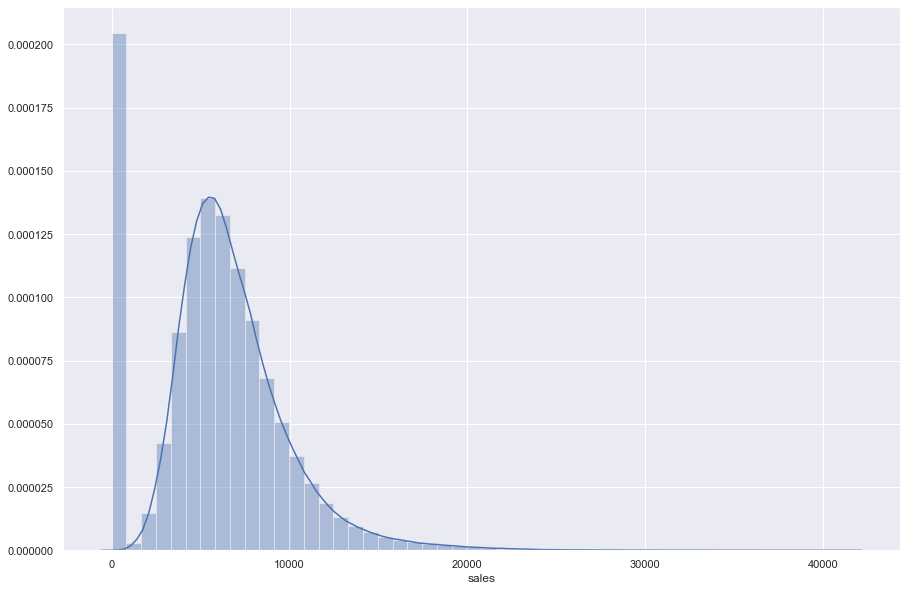

In [190]:
sns.distplot(df1['sales'])

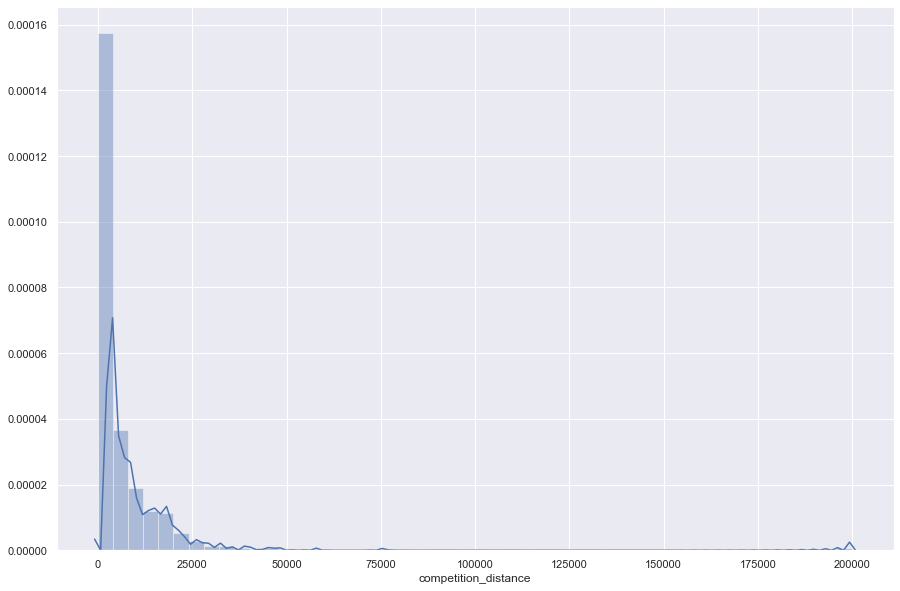

In [191]:
sns.distplot(df1['competition_distance'])

#### 1.7.2 Categorial Attributes

In [192]:
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

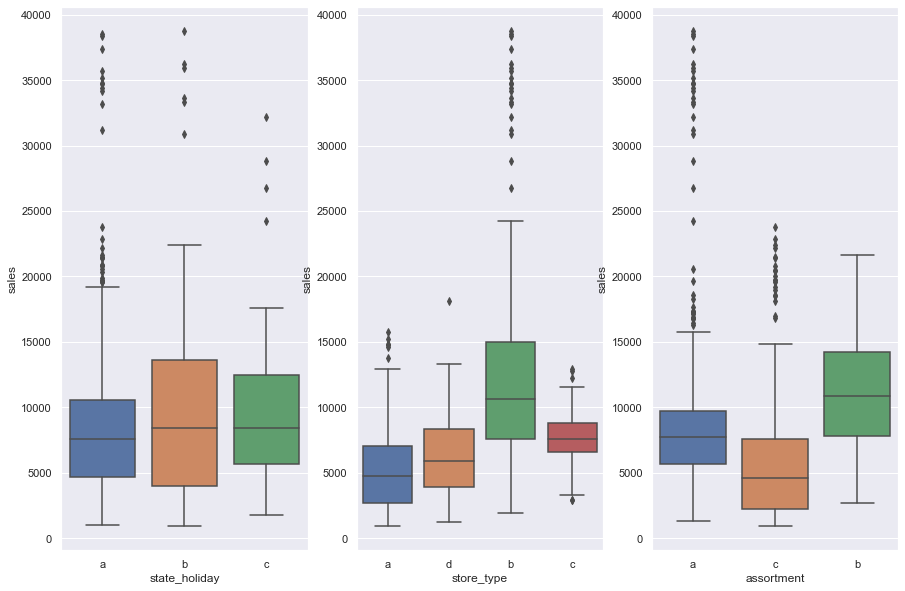

In [193]:
#realizo um filtro do df para trazer somente as vendas em feriados e com vendas
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales']>0)]
plt.subplot(1, 3 ,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3 ,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3 ,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [194]:
df2 = df1.copy()

### 2.1 Hypothesis 

#### 2.1.1 Loja

 **1.** lojas com maior sortimento vendem mais 

 **2.** lojas com competidores mais proximos vendem menos

 **3.** lojas com competidores mais distantes vendem mais

#### 2.1.2 Produto


**1.** lojas com promoções continuas vendem mais

**2.** lojas com mais tempo de promoção vendem mais



#### 2.1.3 Sacionalidade 


**1.** lojas em feriados vendem mais

**2.** lojas vendem mais com o passar dos anos

**3.** lojas com datas de pagamento vendem mais



### 2.2 Feature Engineering

In [195]:
#year
df2['year'] = df2['date'].dt.year
#month
df2['month'] = df2['date'].dt.month
#day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#competion since(mantenho a granularidade em mensal)
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype(int)

#promo since 
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
#a = basic, b = extra, c = extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')
#state holiday
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday'if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day')

In [196]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variaveis

In [197]:
df3 = df2.copy()

In [198]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1 Filtragem das linhas

In [199]:
df3  = df3[(df3['open'] != 0)  & (df3['sales'] > 0)]

### 3.2 Selecao das colunas

In [200]:
cols_drop = ['customers', 'open' , 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [201]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Analise exploratoria de dados

In [202]:
df4 = df3.copy()

### 4.1 Analise Univariada

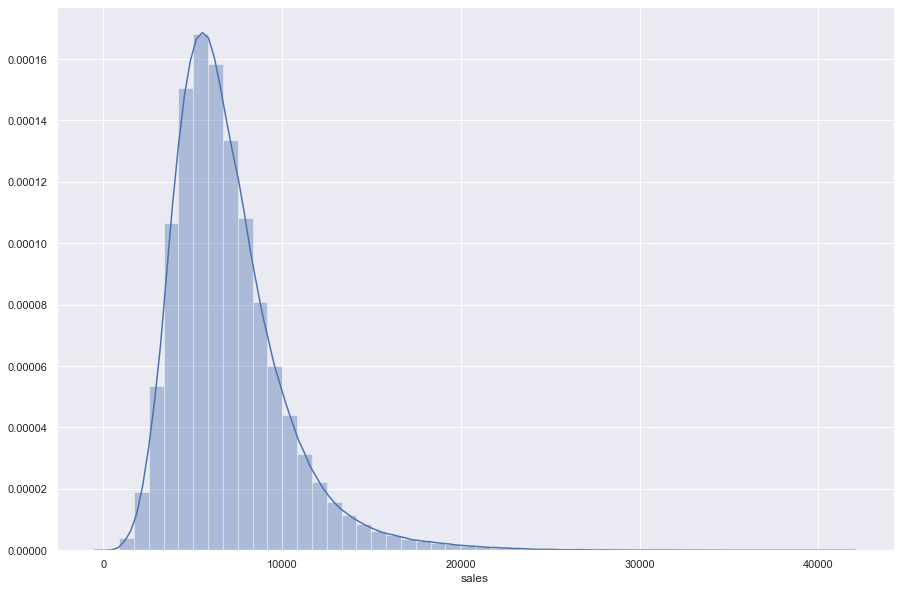

In [203]:
# response variable
sns.distplot(df4['sales'])

<ipython-input-204-067bb5d1da45>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_att.hist(ax=ax,bins=25);


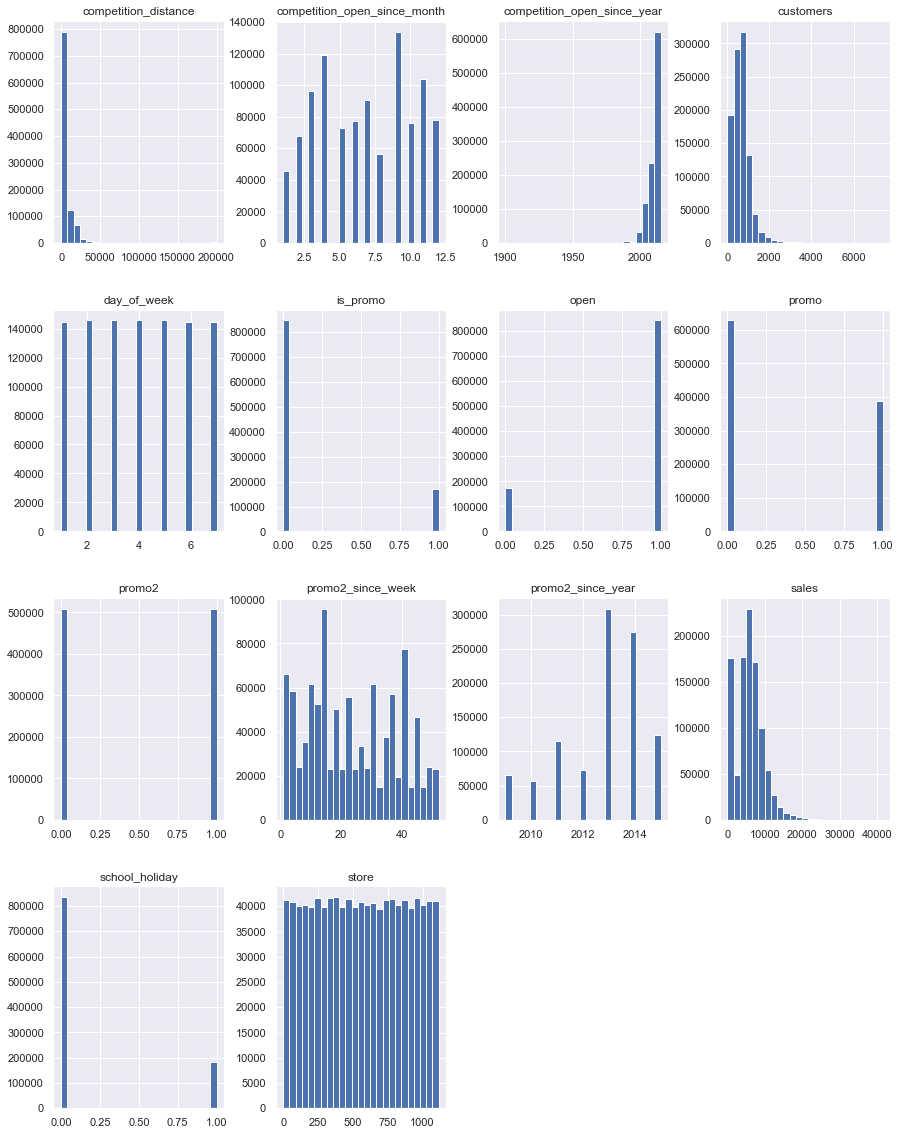

In [204]:
#variaveis numericas
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
num_att.hist(ax=ax,bins=25);

In [205]:
#variaveis categoricas
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

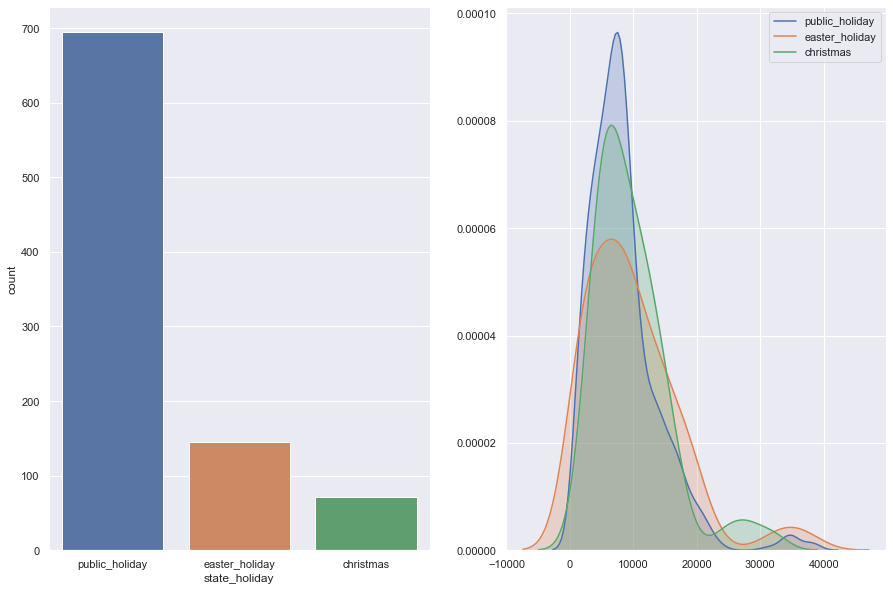

In [206]:
#verifico quais feriados tem mais vendas
#state_holiday
plt.subplot(1,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
#store_type



In [207]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

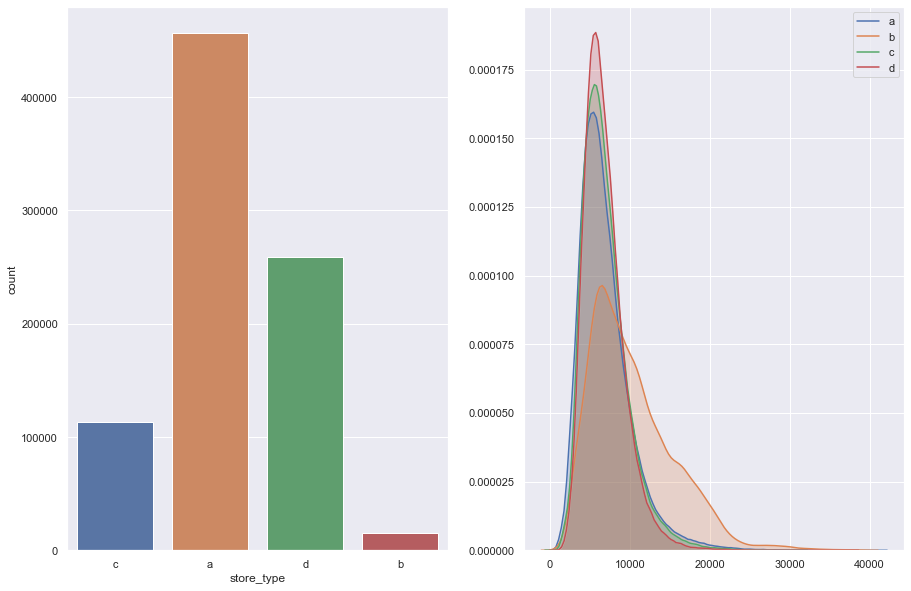

In [208]:
#store_type
plt.subplot(1,2,1)
sns.countplot(df4['store_type'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

In [209]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

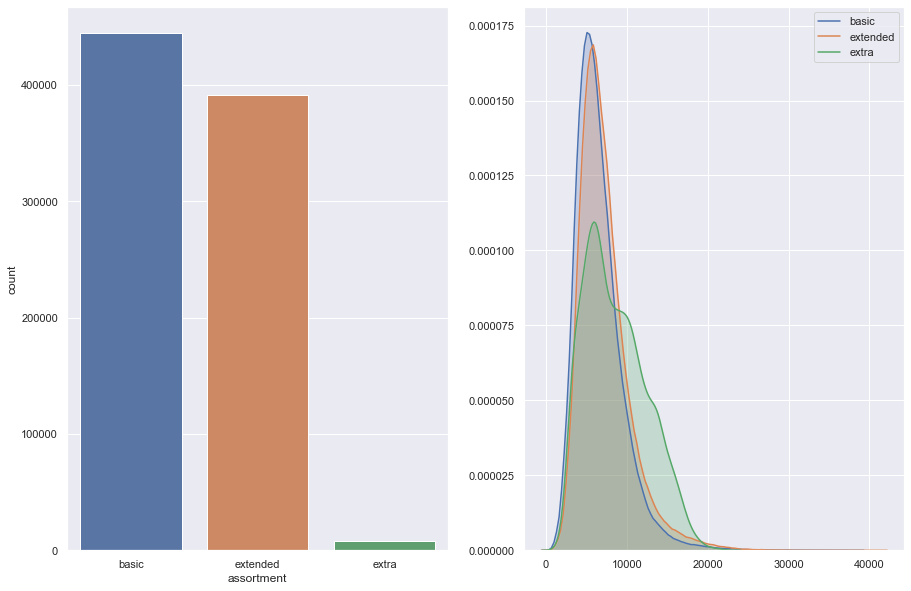

In [210]:
#assortment
plt.subplot(1,2,1)
sns.countplot(df4['assortment'])

plt.subplot(1,2,2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


### 4.1 Analise Bivariada

**H1. Lojas com maiores sortimentos vendem mais?(verificar qtd de lojas de cada tipo)**

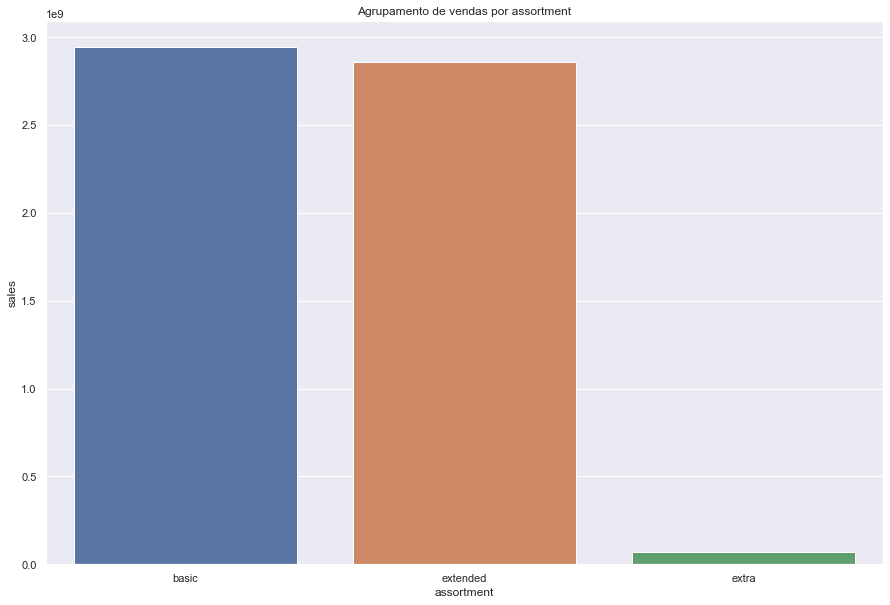

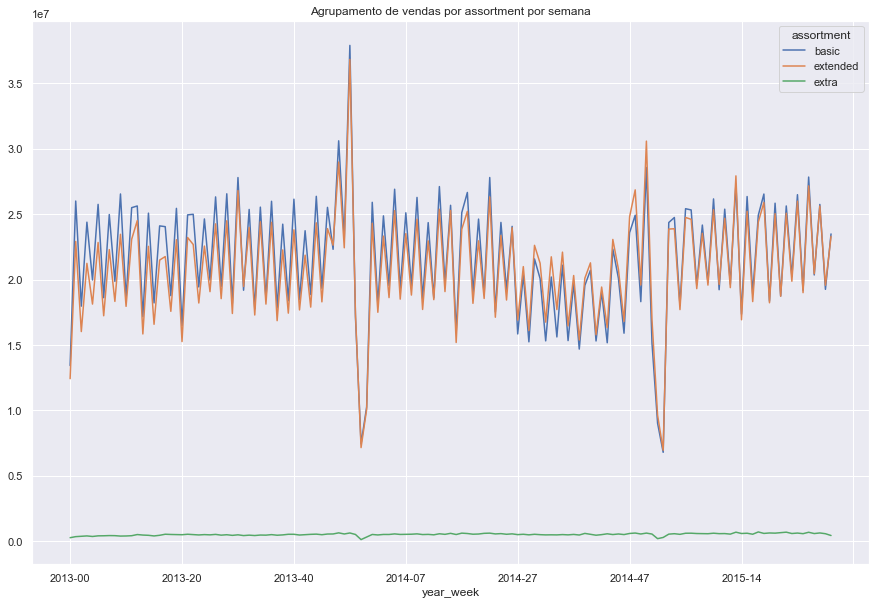

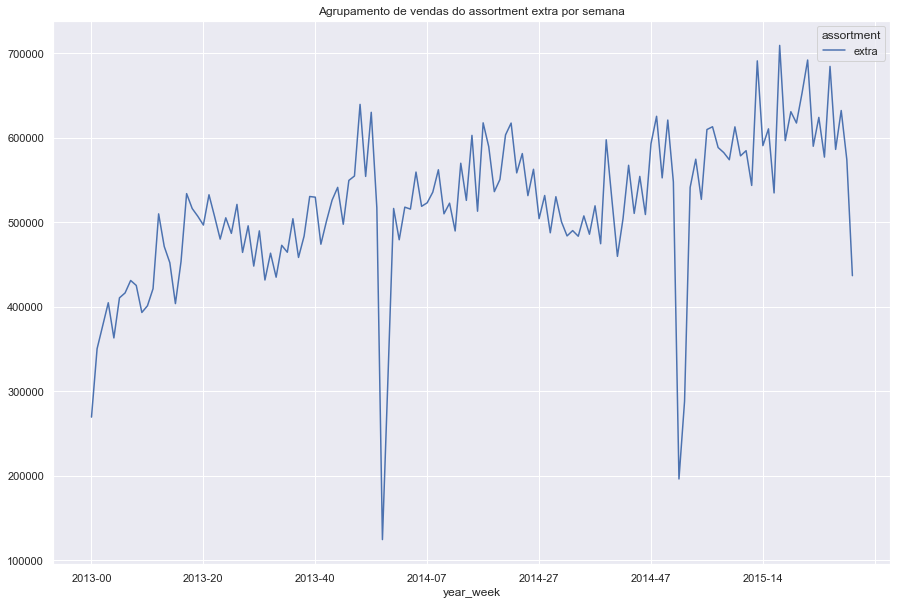

In [211]:
#agrupo os tipos de assortment e somo a quantidade de vendas de cada tipo
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1).set_title('Agrupamento de vendas por assortment')

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot().set_title('Agrupamento de vendas por assortment por semana');

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot().set_title('Agrupamento de vendas do assortment extra por semana');

**H2. Lojas com competidores mais proximos vendem menos**


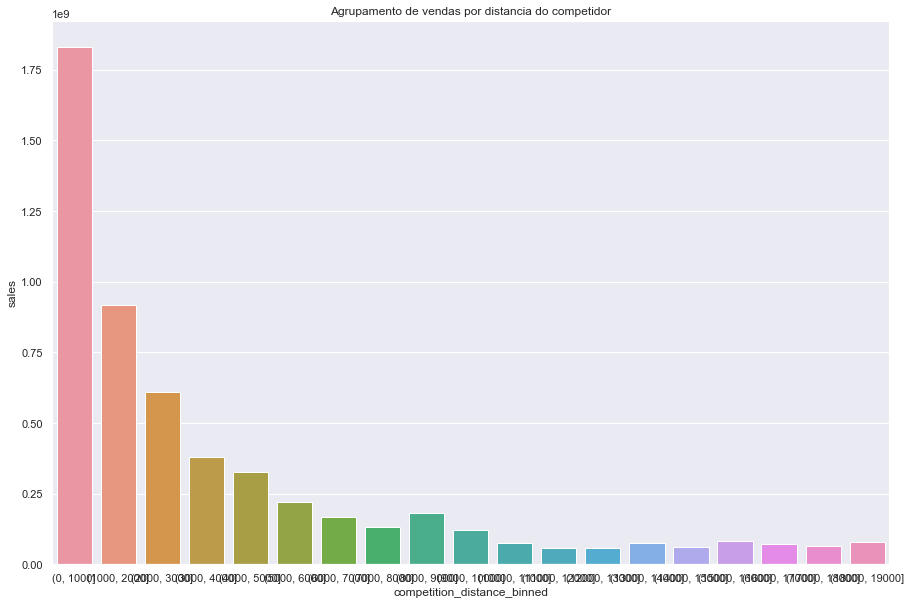

In [212]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
#crio uma lista de ultimo elemento como 20000, sempre pulando de 1000 em 1000
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned']= pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2).set_title('Agrupamento de vendas por distancia do competidor');


In [213]:
aux1.tail()

,competition_distance,sales,competition_distance_binned
650,46590.0,3554993,NaN
651,48330.0,3798660,NaN
652,58260.0,5718883,NaN
653,75860.0,6896821,NaN
654,200000.0,11983829,NaN
